# A mini Xception-like model
In this example, we’ll put toghether all the architectural best practices we saw in chapter 9.3 into a single model.

Its architecture will resemble a smaller version of _Xception_, and we’ll apply it to the [Dogs vs. Cats dataset](https://www.kaggle.com/c/dogs-vs-cats/data), that we already used in [ch. 8-2 notebook](https://github.com/andreaceto/deep-learning-with-python/blob/main/ch08-2_CNN-from-scratch.ipynb).

## Data preparation
### Colab version

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"reaand","key":"ec819941f0faf7e26d94e7a8b3e0b0ab"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [3]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### Local version (if you downloaded the dataset)

In [ ]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory
from constants import DATASETS_DIR_PATH, CATS_VS_DOGS_PATH

# Path to the directory where the original dataset was uncompressed
original_dir = pathlib.Path(CATS_VS_DOGS_PATH)

# Directory where we will store our smaller dataset
new_base_dir = pathlib.Path(os.path.join(DATASETS_DIR_PATH, "dogs_vs_cats_small"))

def make_subset(subset_name, start_index, end_index):
	"""
	Utility function to copy cat (and dog) images from index
	start_index to index end_index to the subdirectory
	new_base_dir/{subset_name}/cat (and /dog). The
	"subset_name" will be either "train", "validation", or "test".
	"""
	for category in ("cat", "dog"):
		dir = new_base_dir / subset_name / category
		os.makedirs(dir)
		fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
		for fname in fnames:
			shutil.copyfile(src=original_dir / fname,
							dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

## Model definition

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [5]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 180, 180,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 176, 176,  │      2,400 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 176, 176,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 176, 176,  │      1,312 │ activation[0][0]  │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 176,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 176, 176,  │      1,312 │ activation_1[0][… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 88, 88,    │          0 │ separable_conv2d… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 88, 88,    │      1,024 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 88, 88,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        128 │ add[0][0]         │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 88, 88,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 88, 88,    │      2,336 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        256 │ separable_conv2d

 Total params: 721,857 (2.75 MB)

 Trainable params: 718,849 (2.74 MB)

 Non-trainable params: 3,008 (11.75 KB)

## Training and validation

In [7]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 219ms/step - accuracy: 0.5281 - loss: 0.7827 - val_accuracy: 0.5210 - val_loss: 0.6925
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.5675 - loss: 0.6843 - val_accuracy: 0.5000 - val_loss: 0.7167
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.6009 - loss: 0.6585 - val_accuracy: 0.5000 - val_loss: 0.6958
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 0.6317 - loss: 0.6436 - val_accuracy: 0.5000 - val_loss: 0.7049
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.6737 - loss: 0.6175 - val_accuracy: 0.5000 - val_loss: 0.7061
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.6922 - loss: 0.6027 - val_accuracy: 0.5370 - val_loss: 0.6889
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - accuracy: 0.6981 - loss: 0.5824 - val_accuracy: 0.5390 - val_loss: 0.7595
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 0.6940 - loss: 0.5896 - 

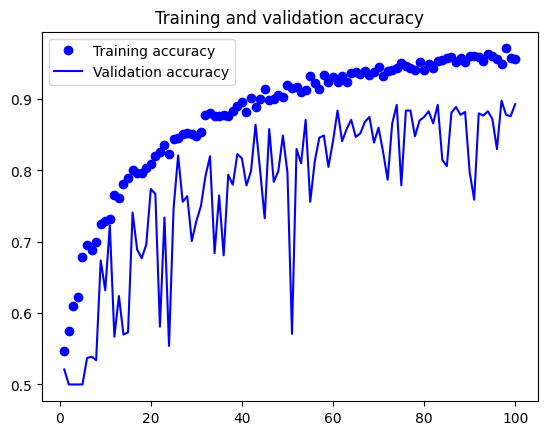

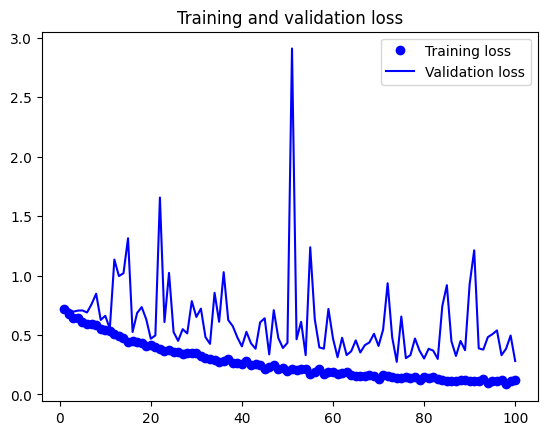

In [8]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()